<a href="https://colab.research.google.com/github/brock-williams/sentiment-analysis-amazon/blob/main/amazon_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import sys
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
dataset = tfds.load('amazon_us_reviews/Personal_Care_Appliances_v1_00', split='train')

df = tfds.as_dataframe(dataset)

df["Sentiment"] = df["data/star_rating"].apply(lambda score: "positive" if score >= 3 else "negative")
df['Sentiment'] = df['Sentiment'].map({'positive':1, 'negative':0})
df['Review'] =df['data/review_body'].str.decode("utf-8")

df = df[["Review", "Sentiment"]]


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/85981 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/amazon_us_reviews/Personal_Care_Appliances_v1_00/0.1.0.incompleteEANKZN/amazon…

Dataset amazon_us_reviews downloaded and prepared to ~/tensorflow_datasets/amazon_us_reviews/Personal_Care_Appliances_v1_00/0.1.0. Subsequent calls will reuse this data.


In [3]:
reviews = df['Review'].values.tolist()
labels = df['Sentiment'].tolist()

stopwords_list = stopwords.words('english')

def clean_df():
  df['Review'] = df['Review'].str.replace('[^a-zA-Z0-9 ]', '')

  # lowercase
  df.Review = df.Review.str.lower()

  # split into list
  df.Review = df.Review.str.split(' ')

  # remove stopwords
  df.Review = df.Review.apply(lambda x: [item for item in x if item not in stopwords_list])

  df.Review = df.Review.apply(' '.join)


clean_df()

Positive = df.loc[df['Sentiment'] == 1]

Negative = df.loc[df['Sentiment'] == 0]



positive_training = Positive[:10000]
negative_training = Negative[:10000]

t_sets = [positive_training, negative_training]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
full_data = pd.concat(t_sets)

sentiment_label = full_data.Sentiment.factorize()


full_data

,Review,Sentiment
0,glasses excellent value fit good comfortable ...,1
1,always wanted try straight razor shaving de sa...,1
2,usually either throw toothbrush plastic bag sp...,1
3,top quality,1
4,today received 1 fl oz natures balance alkama...,1
...,...,...
52055,cheap novelty anything else really want one bu...,0
52069,unfortunately cant really comment flatcomfort ...,0
52080,used product professional stylist chi provides...,0
52081,bought razor month ago well bought one panason...,0


In [13]:
# training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(reviews, labels, test_size=.2)

tokenizer = Tokenizer()

text = full_data.Review.values

tokenizer.fit_on_texts(text)

encoded_data = tokenizer.texts_to_sequences(text)
vocab_size = len(tokenizer.word_index) + 1



In [14]:
padded_sequence = pad_sequences(encoded_data, maxlen=200)

# x_train = tokenizer.texts_to_matrix(text, mode='freq')

# padded_sequence = pad_sequences(encoded_docs, maxlen=200)

# print(x_train.shape)

In [15]:
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 32)           1120096   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,136,747
Trainable params: 1,136,747
Non-trainable params: 0
____________________________________________

In [16]:
history = model.fit(padded_sequence, sentiment_label[0], validation_split=0.2, epochs=5, batch_size=32)


Epoch 1/5
500/500 [==============================] - 103s 201ms/step - loss: 0.4861 - accuracy: 0.7597 - val_loss: 0.4890 - val_accuracy: 0.7575
Epoch 2/5
500/500 [==============================] - 101s 202ms/step - loss: 0.3126 - accuracy: 0.8731 - val_loss: 0.4851 - val_accuracy: 0.7810
Epoch 3/5
500/500 [==============================] - 100s 199ms/step - loss: 0.2450 - accuracy: 0.9056 - val_loss: 0.6303 - val_accuracy: 0.7475
Epoch 4/5
500/500 [==============================] - 99s 199ms/step - loss: 0.1992 - accuracy: 0.9247 - val_loss: 0.6255 - val_accuracy: 0.7520
Epoch 5/5
500/500 [==============================] - 99s 198ms/step - loss: 0.1679 - accuracy: 0.9385 - val_loss: 0.6108 - val_accuracy: 0.7868


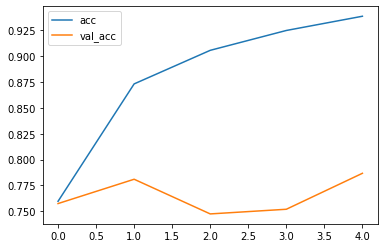

In [18]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

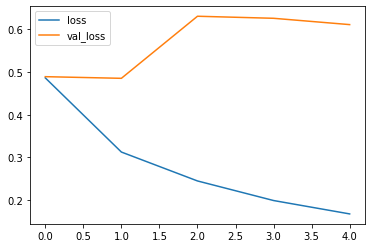

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [20]:
def predict(input):
    text = tokenizer.texts_to_sequences([input])
    text = pad_sequences(text, maxlen=200)
    prediction = int(model.predict(text).round().item())

    if (sentiment_label[1][prediction]) == 1:
      print('Positive sentiment!')
    else:
      print('Negative sentiment... :(')
      
    print("Predicted label: ", sentiment_label[1][prediction])

In [21]:
test = 'Amazing product!'
test2 = 'Hated it... dont buy!'

predict(test)


Positive sentiment!
Predicted label:  1


In [22]:
predict(test2)

Negative sentiment... :(
Predicted label:  0
